### Importing required libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

### Importing datasets

In [66]:
sample_data = pd.read_excel('./assets/sample_data.xlsx', sheet_name="set_6")
# set_1 set_2 set_3 set_4
# X bar - R chart :: set_1, set_2
# X bar - S chart :: set_1, set_2
# C chart :: set_3
# P chart :: set_4, set_5
# XmR chart :: set_6

### Decision tree to decide on which chart to use

In [47]:
## is data discrete or continuous?
try:
    i = 0
    num_col = len(sample_data.columns) - 1
    flag_conti = True
    while i < num_col:
        if (sample_data[i+1]%1 == 0).all():
            flag_conti = False
        i+=1
    if flag_conti:
        print("Data is continuous")
        ## is there more than one data per subgroup?
        flag_subgroup = False
        num_col = len(sample_data.columns) - 1
        if num_col > 1 :
            flag_subgroup = True
            if num_col > 10:
                print("Data will use 'X bar & S chart'")
            else:
                print("Data will use 'X bar & R chart'")
        else:
            print("Data will use 'XmR chart'")
    else:
        print("Data is discrete")
        ## does data follow Poisson distribution or Binomial
        flag_poisson = False
        mean = round(sample_data[1].mean(),0)
        var = round((sample_data[1].var()),0)
        if(mean == var):
            flag_poisson = True
            print("Data will use 'C chart'") ##left differentiation
        else:
            print("Data will use 'P chart'")
except:
    sample_size_temp = sample_data.columns.values[2]
    print("Data is discrete")
    print("Data will use 'P chart'")

Data is continuous
Data will use 'X bar & R chart'


### Plotting the required chart and checking for Anomaly if any

#### X bar - R Chart

X bar Chart:
-->All points within control limits.
-->Process is Out of Control
R Chart
-->All points within control limits.
-->Process is Out of Control


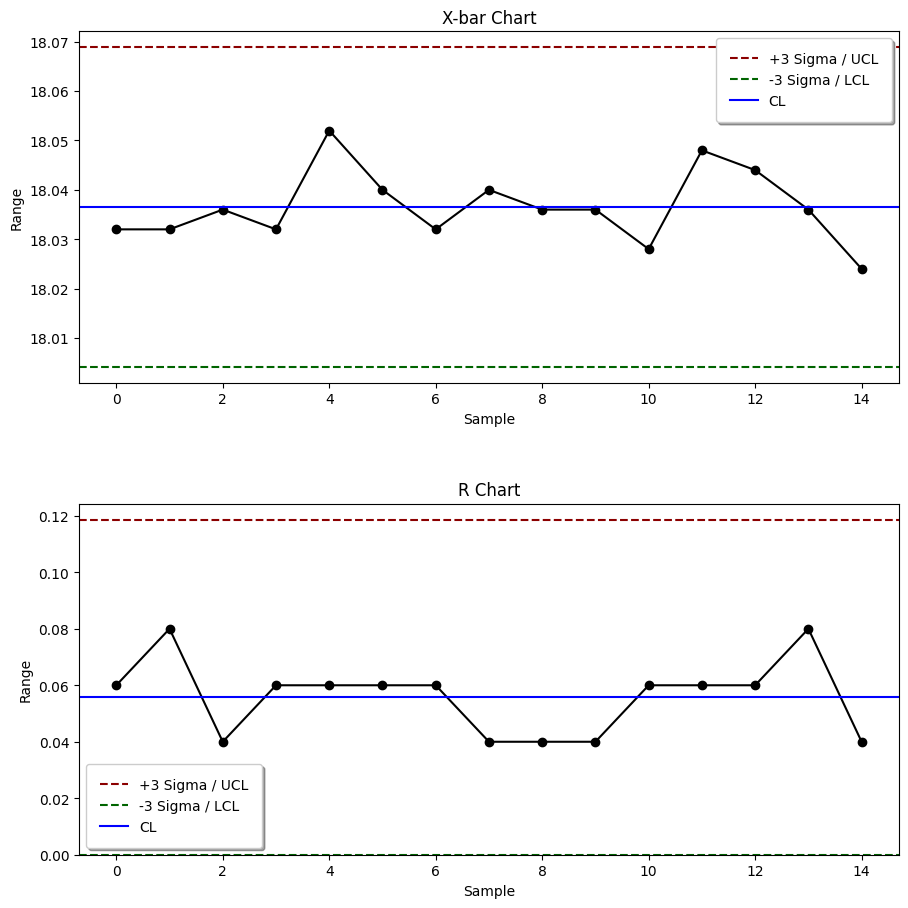

In [53]:
## for x bar & r chart

x = np.array(sample_data.iloc[:,1:].to_numpy())  
## Define list variable for groups means
x_bar = []
## Define list variable for groups ranges
r = [] 
## Get and append groups means and ranges
for group in x:
    x_bar.append(round(group.mean(),3))
    r.append(round(group.max() - group.min(),3))
# Plot x-bar and R charts
fig, axs = plt.subplots(2, figsize=(10,10))

## select appropriate constant value
constants = pd.read_excel('./assets/control_charts_constants.xlsx', sheet_name="Sheet1")
sample_size = len(sample_data.columns) - 1
A2 = constants.loc[constants['m'] == sample_size]['A2']
A2 = float(A2)
D4 = constants.loc[constants['m'] == sample_size]['D4']
D4 = float(D4)
D3 = constants.loc[constants['m'] == sample_size]['D3']
D3 = float(D3)

sigma = np.std(x_bar)
## x-bar chart
# axs[0].plot(x_bar, linestyle='-', marker='o', markersize=10, color='black', linewidth=2)
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((statistics.mean(x_bar)+A2*statistics.mean(r)), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
axs[0].axhline((statistics.mean(x_bar)-A2*statistics.mean(r)), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
axs[0].axhline((statistics.mean(x_bar)), color='blue', label='CL')
# xmax = max(x_bar)
# axs[0].annotate('local max', (4,xmax), (4,xmax),arrowprops=dict(facecolor='yellow', shrink=0.05))
axs[0].set_title('X-bar Chart')
axs[0].set(xlabel='Sample', ylabel='Range')
axs[0].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

## R chart
axs[1].plot(r, linestyle='-', marker='o', color='black')
axs[1].axhline((D4*statistics.mean(r)), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
axs[1].axhline((D3*statistics.mean(r)), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
axs[1].axhline((statistics.mean(r)), color='blue', label='CL')
axs[1].set_ylim(bottom=0)
axs[1].set_title('R Chart')
axs[1].set(xlabel='Sample', ylabel='Range')
axs[1].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

fig.tight_layout(pad=4)

print("X bar Chart:")

# Validate points out of control limits for x-bar chart
i = 0
control = True
for group in x_bar:
    if group > statistics.mean(x_bar)+0.577*statistics.mean(r) or group < statistics.mean(x_bar)-0.577*statistics.mean(r):
        print('-->Sample', i+1, 'out of mean control limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

mean = np.mean(x_bar)
sigma = np.std(x_bar)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=x_bar
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
# from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)
control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")
new_df
print("R Chart")

i = 0
control = True
for group in r:
    if group > 2.574*statistics.mean(r):
        print('-->Sample', i+1, 'out of range cotrol limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

mean = np.mean(r)
sigma = np.std(r)
new_df = pd.DataFrame()
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=r
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

#### X bar - S Chart

X bar Chart:
-->All points within control limits.
-->Process is Out of Control
S Chart:
-->All points within control limits.
-->Process is Out of Control


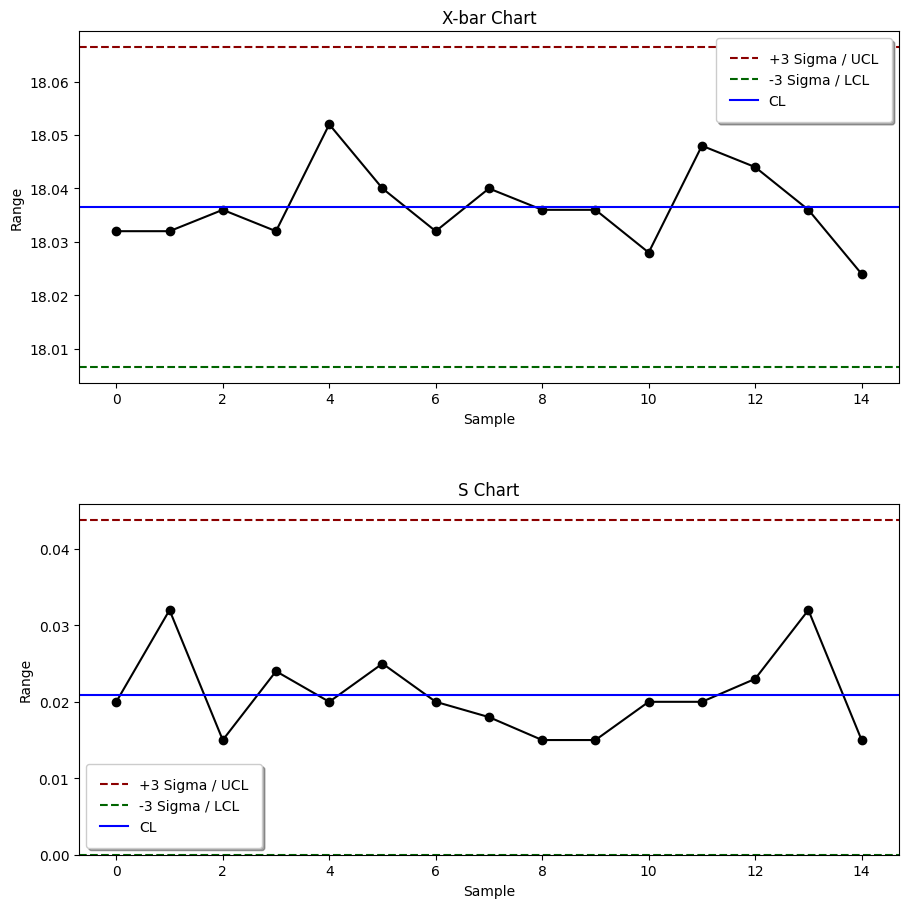

In [52]:
## x bar and S chart

x = np.array(sample_data.iloc[:,1:].to_numpy())  
## Define list variable for groups means
x_bar = []
## Define list variable for groups ranges
s = [] 
## Get and append groups means and ranges
for group in x:
    x_bar.append(round(group.mean(),3))
    s.append(round(group.std(),3))
## Plot x-bar and S charts
fig, axs = plt.subplots(2, figsize=(10,10))

## select appropriate constant value
constants = pd.read_excel('./assets/control_charts_constants.xlsx', sheet_name="Sheet1")
sample_size = len(sample_data.columns) - 1
A3 = constants.loc[constants['m'] == sample_size]['A3']
A3 = float(A3)
B4 = constants.loc[constants['m'] == sample_size]['B4']
B4 = float(B4)
B3 = constants.loc[constants['m'] == sample_size]['B3']
B3 = float(B3)

## x-bar chart
# axs[0].plot(x_bar, linestyle='-', marker='o', markersize=10, color='black', linewidth=2)
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((statistics.mean(x_bar)+A3*statistics.mean(s)), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
axs[0].axhline((statistics.mean(x_bar)-A3*statistics.mean(s)), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
axs[0].axhline((statistics.mean(x_bar)), color='blue', label='CL')
axs[0].set_title('X-bar Chart')
axs[0].set(xlabel='Sample', ylabel='Range')
axs[0].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

## S chart
axs[1].plot(s, linestyle='-', marker='o', color='black')
axs[1].axhline((B4*statistics.mean(s)), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
axs[1].axhline((B3*statistics.mean(s)), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
axs[1].axhline((statistics.mean(s)), color='blue', label='CL')
axs[1].set_ylim(bottom=0)
axs[1].set_title('S Chart')
axs[1].set(xlabel='Sample', ylabel='Range')
axs[1].legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

fig.tight_layout(pad=4)

print("X bar Chart:")

# Validate points out of control limits for x-bar chart
i = 0
control = True
for group in x_bar:
    if group > statistics.mean(x_bar)+0.927*statistics.mean(s) or group < statistics.mean(x_bar)-0.927*statistics.mean(s):
        print('-->Sample', i+1, 'out of mean control limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

mean = np.mean(x_bar)
sigma = np.std(x_bar)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=x_bar
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

print("S Chart:")

i = 0
control = True
for group in s:
    if group > 1.649*statistics.mean(s) or group < 0.321*statistics.mean(s):
        print('-->Sample', i+1, 'out of standard deviation cotrol limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

mean = np.mean(s)
sigma = np.std(s)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=s
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

#### C Chart

C Chart:
-->All points within control limits.
-->Process is Out of Control


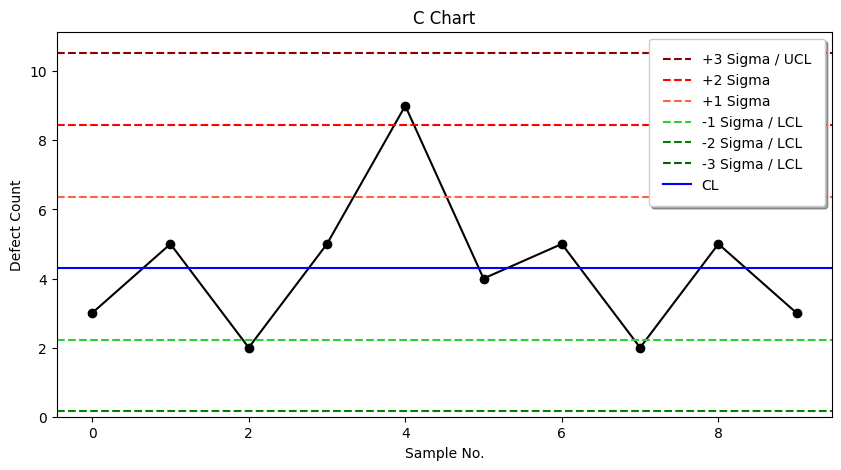

In [39]:
## for c chart

c = sample_data
# Plot c-chart
plt.figure(figsize=(10,5))
plt.plot(c[1], linestyle='-', marker='o', color='black')
plt.axhline(statistics.mean(c[1])+3*np.sqrt(statistics.mean(c[1])), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
plt.axhline(statistics.mean(c[1])+2*np.sqrt(statistics.mean(c[1])), color='red', linestyle='dashed', label='+2 Sigma')
plt.axhline(statistics.mean(c[1])+1*np.sqrt(statistics.mean(c[1])), color='tomato', linestyle='dashed', label='+1 Sigma')
plt.axhline(statistics.mean(c[1])-1*np.sqrt(statistics.mean(c[1])), color='limegreen', linestyle='dashed', label='-1 Sigma / LCL')
plt.axhline(statistics.mean(c[1])-2*np.sqrt(statistics.mean(c[1])), color='green', linestyle='dashed', label='-2 Sigma / LCL')
plt.axhline(statistics.mean(c[1])-3*np.sqrt(statistics.mean(c[1])), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
plt.axhline(statistics.mean(c[1]), color='blue', label='CL')
plt.ylim(bottom=0)
plt.title('C Chart')
plt.xlabel('Sample No.')
plt.ylabel('Defect Count')
plt.legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)
print("C Chart:")

# Anomaly Detection
i = 0
control = True
for group in c[1]:
    if group > statistics.mean(c[1])+3*np.sqrt(statistics.mean(c[1])) or group < statistics.mean(c[1])-3*np.sqrt(statistics.mean(c[1])):
        print('-->Sample', i+1, 'out of defects cotrol limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

c = sample_data[1]
mean = np.mean(c)
sigma = np.std(c)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=c
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

#### P Chart

P Chart:
-->Sample 13 out of fraction defective cotrol limits!
-->Process is Out of Control


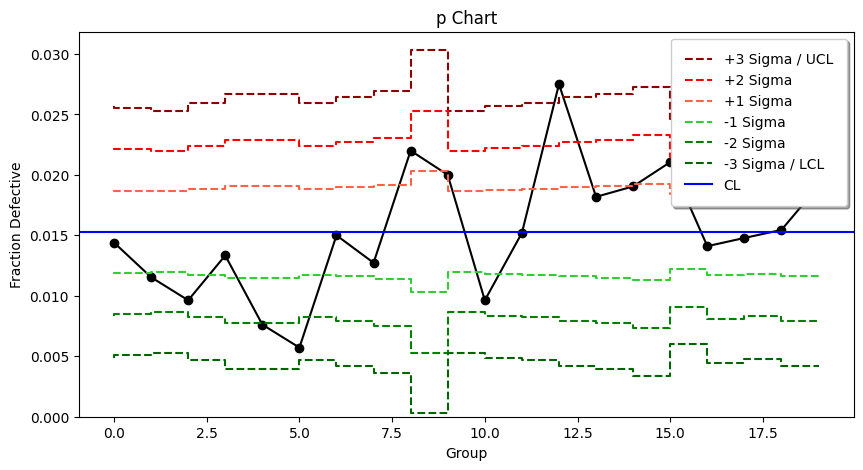

In [35]:
p=sample_data
p['p'] = p[1]/p['sample_size']

# Plot p-chart
plt.figure(figsize=(10,5))
plt.plot(p['p'], linestyle='-', marker='o', color='black')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='darkred', linestyle='dashed', label='+3 Sigma / UCL')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='red', linestyle='dashed', label='+2 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])+1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='tomato', linestyle='dashed', label='+1 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-1*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='limegreen', linestyle='dashed', label='-1 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-2*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='green', linestyle='dashed', label='-2 Sigma')
plt.step(x=range(0,len(p['p'])), y=statistics.mean(p['p'])-3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/(p['sample_size']))), color='darkgreen', linestyle='dashed', label='-3 Sigma / LCL')
plt.axhline(statistics.mean(p['p']), color='blue', label="CL")
plt.ylim(bottom=0)
plt.title('p Chart')
plt.xlabel('Group')
plt.ylabel('Fraction Defective')
plt.legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)
print("P Chart:")

# Anomaly Detection
i = 0
control = True
for group in p['p']:
    if group > (statistics.mean(p['p'])+3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/statistics.mean(p['sample_size'])))) or group < (statistics.mean(p['p'])-3*(np.sqrt((statistics.mean(p['p'])*(1-statistics.mean(p['p'])))/statistics.mean(p['sample_size'])))):
        print('-->Sample', i+1, 'out of fraction defective cotrol limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')

p = sample_data[1]
mean = np.mean(p)
sigma = np.std(p)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=p
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

#### XmR Chart


XmR Chart:
All points within control limits.
-->Process is Out of Control


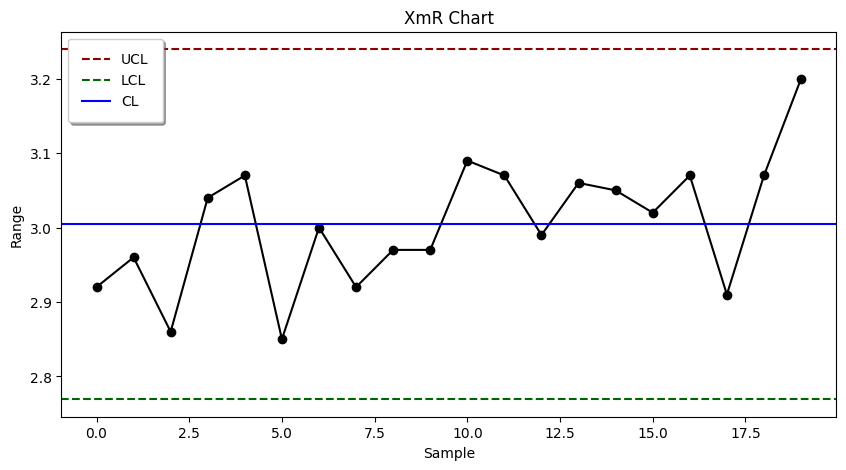

In [128]:
x = np.array(sample_data.iloc[:,1:].to_numpy())

mR=[np.nan]
i = 1
for data in range(1, len(x)):
    mR.append(abs(x[i] - x[i-1]))
    i += 1

# Convert list to pandas Series objects    
mR = pd.Series(mR)
mR=mR.str[0]
x = pd.Series(x.tolist())
x=x.str[0]
# # Concatenate mR Series with and rename columns
data = pd.concat([x,mR], axis=1).rename(columns={0:"x", 1:"mR"})

# # Plot x and mR charts
plt.figure(figsize=(10,5))
plt.plot(data['x'], linestyle='-', marker='o', color='black')
plt.axhline(statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'darkred', linestyle = 'dashed', label='UCL')
plt.axhline(statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128, color = 'darkgreen', linestyle = 'dashed', label='LCL')
plt.axhline(statistics.mean(data['x']), color='blue', label="CL")
plt.title('XmR Chart')
plt.xlabel('Sample')
plt.ylabel('Range')
plt.legend(fancybox=True, framealpha=1, shadow=True,frameon=True, borderpad=1)

print("XmR Chart:")

# Anomaly Detection
i = 0
control = True
for unit in data['x']:
    if unit > statistics.mean(data['x'])+3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128 or unit < statistics.mean(data['x'])-3*statistics.mean(data['mR'][1:len(data['mR'])])/1.128:
        print('Unit', i, 'out of control limits!')
        control = False
    i += 1
if control == True:
    print('-->All points within control limits.')    

mean = np.mean(x)
sigma = np.std(x)
new_df = pd.DataFrame(columns=['index','amount'])
new_df['amount']=p
new_df['index'] = range(1,len(new_df['amount'])+1)
new_df = new_df.set_index('index')
from detector import AnomalyDetector
detector = AnomalyDetector()
detector.rule1(new_df,mean,sigma)
detector.rule2(new_df, mean)
detector.rule3(new_df)
detector.rule4(new_df)
detector.rule5(new_df, mean, sigma)
detector.rule6(new_df, mean, sigma)
detector.rule7(new_df, mean, sigma)
detector.rule8(new_df, mean, sigma)

control_check=False
for x in new_df.any(axis=1) :
    if x==True :
        control_check=True
        break
if control_check==False :
    print("-->Process is in Control")
else :
    print("-->Process is Out of Control")

# Anomaly Detector Function

In [4]:
class AnomalyDetector:      

    # Rule 1: One point is more than 3 standard deviations from the mean (outlier)
    def rule1(self, data, mean, sigma):

        def isBetween(value, lower, upper):
            isBetween = value < upper and value > lower
            return 0 if isBetween else 1

        upperLimit = mean + 3 * sigma
        lowerLimit = mean - 3 * sigma

        data['Rule1'] = data.apply(lambda row: isBetween(row['amount'], lowerLimit, upperLimit), axis = 1)

    # Rule 2: Nine (or more) points in a row are on the same side of the mean (shift)
    def rule2(self, data, mean):
        values = [0]*len(data)

        # +1 means upside, -1 means downside
        upsideOrDownside = 0
        count = 0
        for i in range(len(data)):
            amount = data.iloc[i]['amount']
            if amount > mean:
                if upsideOrDownside == 1:
                    count += 1
                else: 
                    upsideOrDownside = 1
                    count = 1
            elif amount < mean: 
                if upsideOrDownside == -1:
                    count += 1
                else: 
                    upsideOrDownside = -1
                    count = 1

            if count >= 9:
                values[i] = 1

        data['Rule2'] = values              

    # Rule 3: Six (or more) points in a row are continually increasing (or decreasing) (trend)
    def rule3(self, data):
        values = [0]*len(data)

        previousAmount = data.iloc[0]['amount']
        # +1 means increasing, -1 means decreasing
        increasingOrDecreasing = 0
        count = 0
        for i in range(1, len(data)):
            amount = data.iloc[i]['amount']
            if amount > previousAmount:
                if increasingOrDecreasing == 1:
                    count += 1
                else:
                    increasingOrDecreasing = 1
                    count = 1
            elif amount < previousAmount:
                if increasingOrDecreasing == -1:
                    count += 1
                else:
                    increasingOrDecreasing = -1
                    count = 1

            if count >= 6:
                values[i] = 1

            previousAmount = amount

        data['Rule3'] = values 

    # Rule 4: Fourteen (or more) points in a row alternate in direction, increasing then decreasing (bimodal, 2 or more factors in data set)
    def rule4(self, data):
        values = [0]*len(data)

        previousAmount = data.iloc[0]['amount']
        # +1 means increasing, -1 means decreasing
        bimodal = 0
        count = 1
        for i in range(1, len(data)):
            amount = data.iloc[i]['amount']
            
            if amount > previousAmount:
                bimodal += 1
                if abs(bimodal) != 1:
                    count = 0
                    bimodal = 0
                else:
                    count += 1
            elif amount < previousAmount:
                bimodal -= 1
                if abs(bimodal) != 1:
                    count = 0
                    bimodal = 0
                else:
                    count += 1

            previousAmount = amount

            if count >= 14:
                values[i] = 1

        data['Rule4'] = values 

    # Rule 5: Two (or three) out of three points in a row are more than 2 standard deviations from the mean in the same direction (shift)
    def rule5(self, data, mean, sigma):
        if len(data) < 3: return

        values = [0]*len(data)
        upperLimit = mean - 2 * sigma
        lowerLimit = mean + 2 * sigma        

        for i in range(len(data) - 3):
            first = data.iloc[i]['amount']
            second = data.iloc[i+1]['amount']
            third = data.iloc[i+2]['amount']
            
            setValue = False
            validCount = 0
            if first > mean and second > mean and third > mean:
                validCount += 1 if first > lowerLimit else 0
                validCount += 1 if second > lowerLimit else 0
                validCount += 1 if third > lowerLimit else 0
                setValue = validCount >= 2
            elif first < mean and second < mean and third < mean:
                validCount += 1 if first < upperLimit else 0
                validCount += 1 if second < upperLimit else 0
                validCount += 1 if third < upperLimit else 0
                setValue = validCount >= 2

            if setValue:
                values[i+2] = 1

        data['Rule5'] = values

    # Rule 6: Four (or five) out of five points in a row are more than 1 standard deviation from the mean in the same direction (shift or trend)
    def rule6(self, data, mean, sigma):
        if len(data) < 5: return

        values = [0]*len(data)
        upperLimit = mean - sigma
        lowerLimit = mean + sigma   

        for i in range(len(data) - 5):
            pVals = list(map(lambda x: data.iloc[x]['amount'], range(i, i+5)))

            setValue = False
            if len(list(filter(lambda x: x > mean, pVals))) == 5:
                setValue = len(list(filter(lambda x: x > lowerLimit, pVals))) >= 4
            elif len(list(filter(lambda x: x < mean, pVals))) == 5:
                setValue = len(list(filter(lambda x: x < upperLimit, pVals))) >= 4

            if setValue:
                values[i+4] = 1

        data['Rule6'] = values

    # Rule 7: Fifteen points in a row are all within 1 standard deviation of the mean on either side of the mean (reduced variation or measurement issue)
    def rule7(self, data, mean, sigma):
        if len(data) < 15: return
        values = [0]*len(data)
        upperLimit = mean + sigma
        lowerLimit = mean - sigma 
        
        for i in range(len(data) - 15):
            setValue = True
            for y in range(15):
                item = data.iloc[i + y]['amount']
                if item >= upperLimit or item <= lowerLimit: 
                    setValue = False
                    break
            
            if setValue:
                values[i+14] = 1

        data['Rule7'] = values

    # Rule 8: Eight points in a row exist with none within 1 standard deviation of the mean and the points are in both directions from the mean (bimodal, 2 or more factors in data set)
    def rule8(self, data, mean, sigma):
        if len(data) < 8: return
        values = [0]*len(data)

        for i in range(len(data) - 8):
            setValue = True
            for y in range(8):
                item = data.iloc[i + y]['amount']
                if abs(mean - item) < sigma:
                    setValue = False
                    break

            if setValue:
                values[i+8] = 1

        data['Rule8'] = values